In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import classification_report

2024-08-17 09:57:32.995789: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-17 09:57:32.995893: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-17 09:57:33.115434: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


##### Run Tensorflow on GPU

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        print(f"Name: {gpu.name}, Type: {gpu.device_type}")

Name: /physical_device:GPU:0, Type: GPU


In [4]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpu_devices[0], 'GPU')

# Importing & EDA

In [5]:
df_path=r'/kaggle/input/butterfly-image-classification/Training_set.csv'
df=pd.read_csv(df_path)
df.head()

,filename,label
0,Image_1.jpg,SOUTHERN DOGFACE
1,Image_2.jpg,ADONIS
2,Image_3.jpg,BROWN SIPROETA
3,Image_4.jpg,MONARCH
4,Image_5.jpg,GREEN CELLED CATTLEHEART


In [6]:
df.shape

(6499, 2)

In [7]:
len(df.label.unique())

75

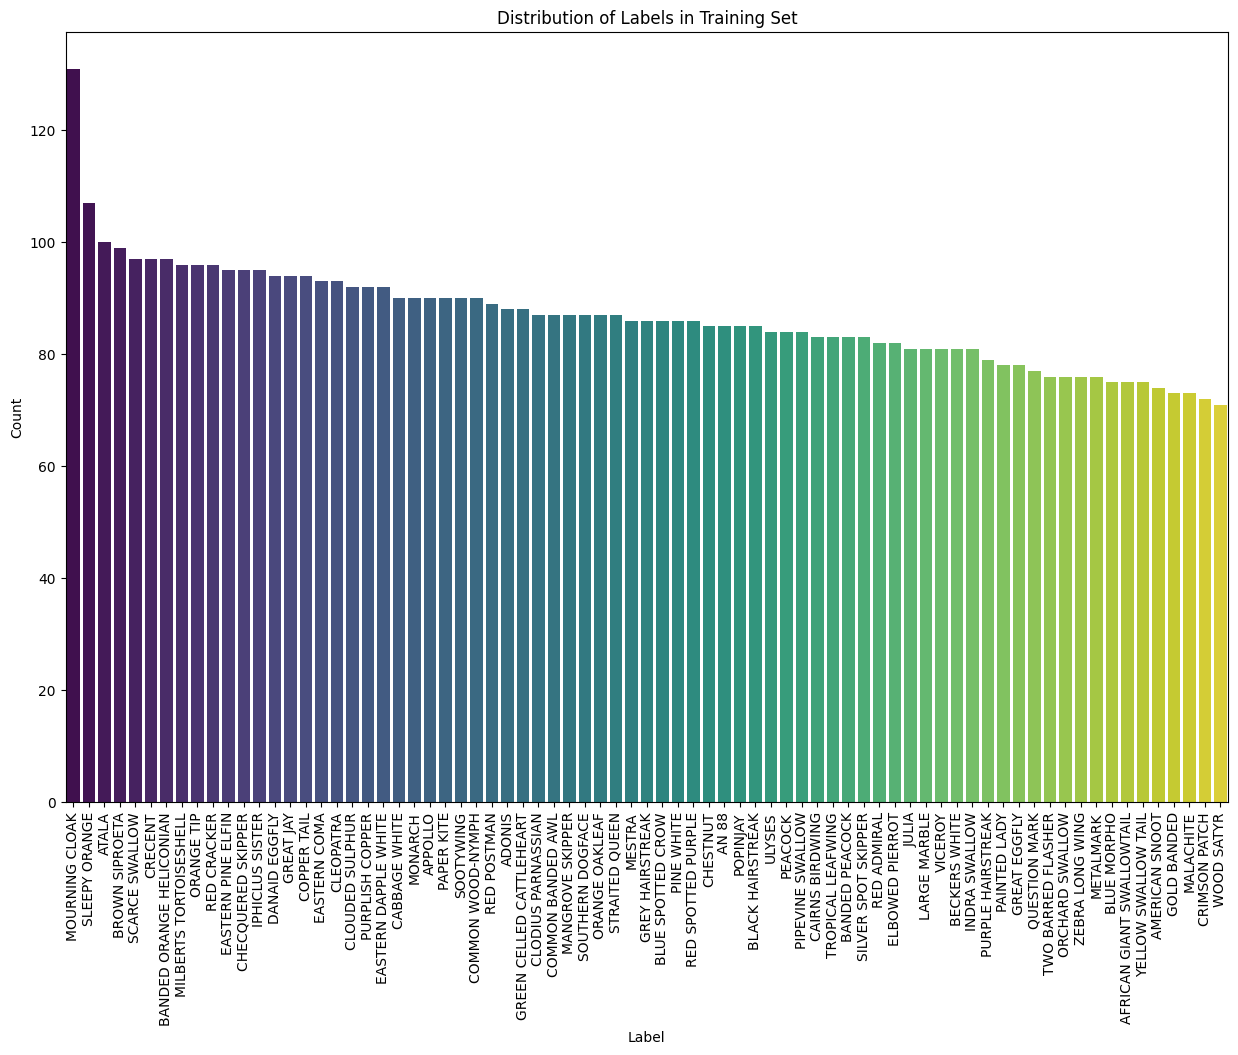

In [8]:
label_distribution = df['label'].value_counts()
plt.figure(figsize=(15, 10))
sns.barplot(x=label_distribution.index, y=label_distribution.values, palette='viridis')
plt.title('Distribution of Labels in Training Set')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

# Preprocessing Images

### Choosing Randomly 3000 images

In [9]:
sampled_train_df = df.sample(n=3000, random_state=42)
label_distribution_sampled = sampled_train_df['label'].value_counts()
sampled_train_df.head()

,filename,label
5572,Image_5573.jpg,GREEN CELLED CATTLEHEART
1703,Image_1704.jpg,MONARCH
5862,Image_5863.jpg,QUESTION MARK
1773,Image_1774.jpg,APPOLLO
5709,Image_5710.jpg,BANDED PEACOCK


In [10]:
len(sampled_train_df.label.unique())

75

## Preprocessing Steps

In [11]:
train_dir=r'/kaggle/input/butterfly-image-classification/train'
test_dir=r'/kaggle/input/butterfly-image-classification/test'

train_datagen=ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen=ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=sampled_train_df,
    directory=train_dir,
    x_col='filename',
    y_col='label',
    subset='training',
    target_size=(224, 224),  # Image size
    batch_size=32,
    class_mode='categorical'
)

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=sampled_train_df,
    directory=train_dir,
    x_col='filename',
    y_col='label',
    subset='validation',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 2400 validated image filenames belonging to 75 classes.
Found 600 validated image filenames belonging to 75 classes.
Found 0 images belonging to 0 classes.


# Evaluation Functions

In [34]:
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    
    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    
    plt.tight_layout()
    plt.show()

In [35]:
def evaluate_model(model, test_generator):
    predictions = model.predict(test_generator)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_generator.classes
    print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))

# Models

In [36]:
num_classes = len(train_generator.class_indices)
num_classes

75

In [37]:
def build_cnn():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [38]:
def build_vgg16():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    for layer in base_model.layers:
        layer.trainable = False
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [39]:
def build_resnet50():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    for layer in base_model.layers:
        layer.trainable = False
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Train Models

In [40]:
cnn_model = build_cnn()
vgg16_model = build_vgg16()
resnet50_model = build_resnet50()

## Training and Evaluating

### CNN Model

In [41]:
history_cnn = cnn_model.fit(train_generator, validation_data=validation_generator, epochs=30)

Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - accuracy: 0.0285 - loss: 4.7255 - val_accuracy: 0.1650 - val_loss: 11.0558
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.1900 - loss: 3.3835 - val_accuracy: 0.3133 - val_loss: 10.8708
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.4852 - loss: 2.0618 - val_accuracy: 0.3700 - val_loss: 12.7444
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - accuracy: 0.7462 - loss: 0.9856 - val_accuracy: 0.3667 - val_loss: 25.7459
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.8827 - loss: 0.4626 - val_accuracy: 0.3917 - val_loss: 32.2361
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.9271 - loss: 0.2836 - val_accuracy: 0.3400 - val_loss: 29.6444
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.9435 - loss: 0.2270 - val_accuracy: 0.3717 - val_loss: 34.5154
Epoch 8/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.9751 - loss: 0.1203 - val_accuracy: 0.

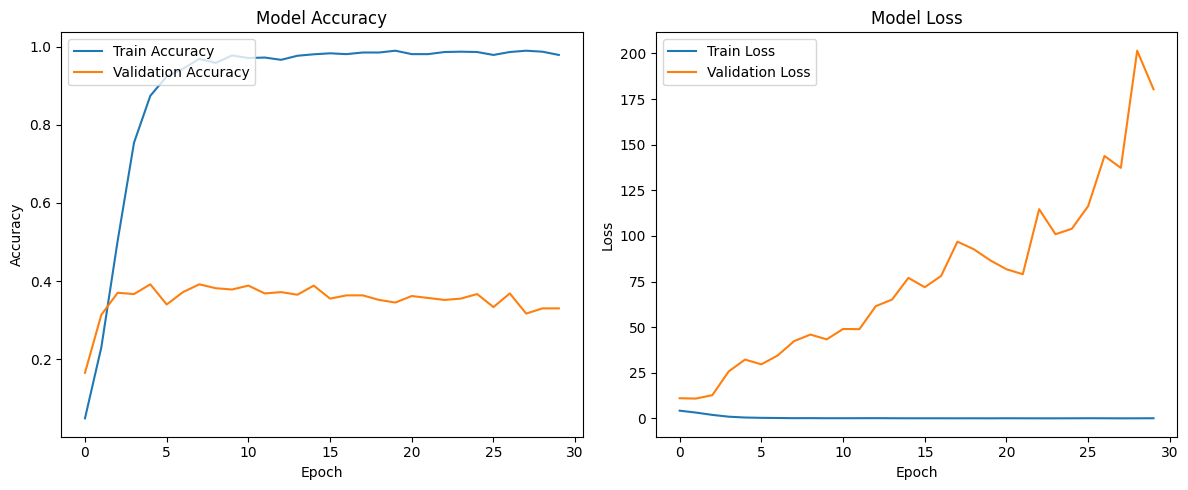

In [42]:
plot_training_history(history_cnn)

In [43]:
#evaluate_model(cnn_model, test_generator)

### VGG 16

In [44]:
history_vgg = vgg16_model.fit(train_generator, validation_data=validation_generator, epochs=30)

Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - accuracy: 0.0252 - loss: 4.3720 - val_accuracy: 0.1933 - val_loss: 3.8864
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - accuracy: 0.1745 - loss: 3.7094 - val_accuracy: 0.3250 - val_loss: 3.2288
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - accuracy: 0.3160 - loss: 3.0384 - val_accuracy: 0.4067 - val_loss: 2.7264
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - accuracy: 0.4042 - loss: 2.5714 - val_accuracy: 0.4583 - val_loss: 2.3490
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - accuracy: 0.4796 - loss: 2.1692 - val_accuracy: 0.5600 - val_loss: 2.0345
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - accuracy: 0.5190 - loss: 1.9668 - val_accuracy: 0.5733 - val_loss: 1.8174
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - accuracy: 0.5759 - loss: 1.7661 - val_accuracy: 0.6067 - val_loss: 1.6990
Epoch 8/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - accuracy: 0.6072 - loss: 1.5827 - val_accuracy: 0.6033 -

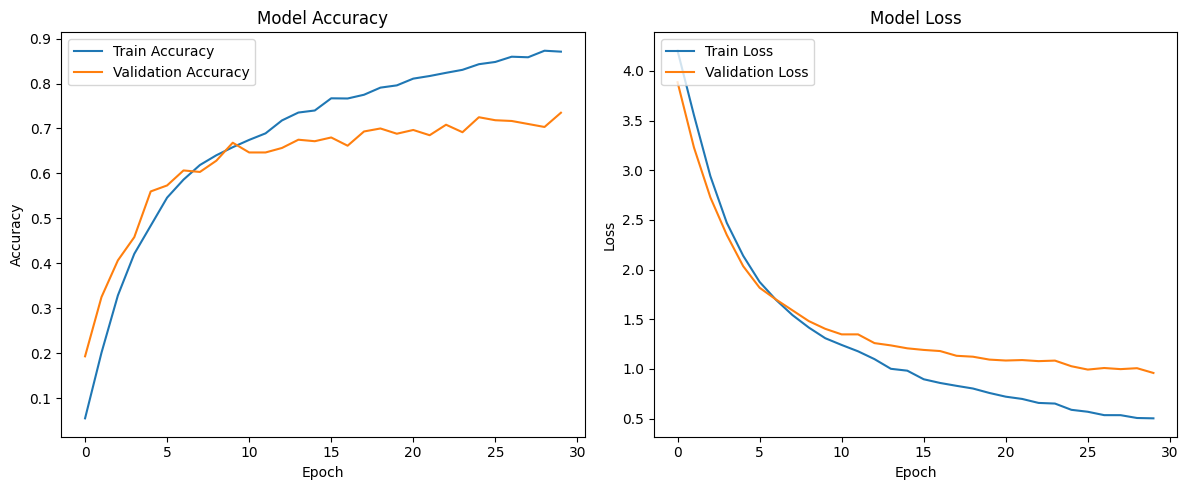

In [45]:
plot_training_history(history_vgg)

In [46]:
#evaluate_model(vgg16_model, test_generator)

### ResNet

In [47]:
history_resnet = resnet50_model.fit(train_generator, validation_data=validation_generator, epochs=30)

Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 22s 147ms/step - accuracy: 0.0205 - loss: 4.4921 - val_accuracy: 0.0200 - val_loss: 4.2372
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 0.0332 - loss: 4.2129 - val_accuracy: 0.0367 - val_loss: 4.1111
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.0398 - loss: 4.1214 - val_accuracy: 0.0500 - val_loss: 4.0283
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - accuracy: 0.0425 - loss: 4.0571 - val_accuracy: 0.0683 - val_loss: 3.9482
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 0.0645 - loss: 3.9776 - val_accuracy: 0.0967 - val_loss: 3.8667
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 0.0701 - loss: 3.9114 - val_accuracy: 0.1000 - val_loss: 3.7791
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.0737 - loss: 3.8594 - val_accuracy: 0.1200 - val_loss: 3.7265
Epoch 8/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.0726 - loss: 3.8161 - val_accuracy: 0.1300 -

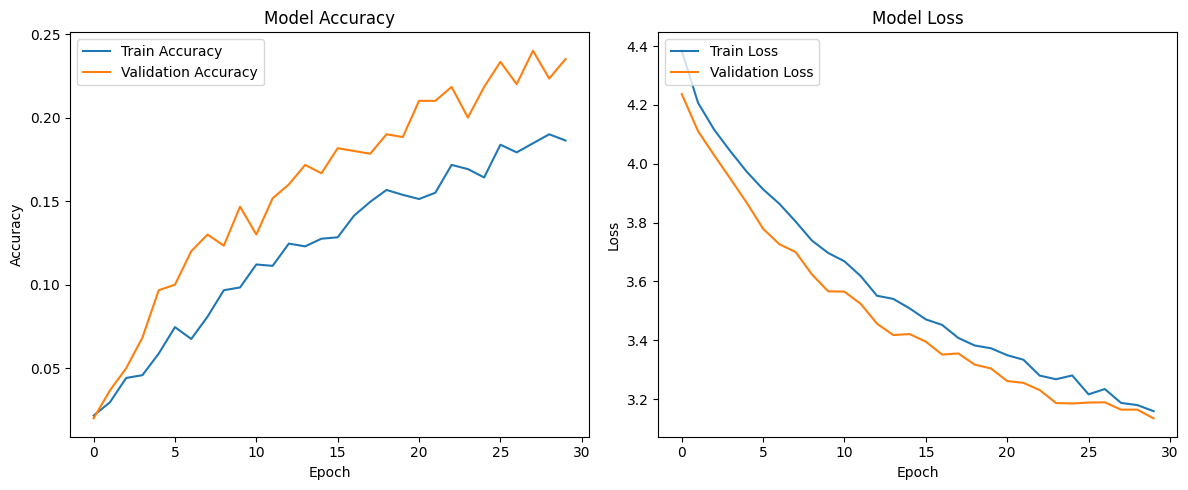

In [48]:
plot_training_history(history_resnet)

In [49]:
#evalute_model(resnet50_model, test_generator)